In [2]:
# Autograd basics
import autograd.numpy as jnp # thinly wrapped numpy
from autograd import grad # function that creates gradient functions

def tanh(x):
    y = jnp.exp(x)
    return (1.0-y) /(1.0+y)

# create a function that computes the gradient of tanh
grad_tanh = grad(tanh)

print(grad_tanh(1.0))

-0.3932238664829636


In [16]:
# Pytorch can add gpu support
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import torch

%matplotlib inline

x = torch.tensor([1.0,2.0,3.0,4.0]) # constructs a tensor with no autograd history

# create tensor from numpy array. they share the memory so that the modifications made to tensor will be reflected in numpy array and vice versa
x_np = np.array([1.0,2.0,3.0,4.0] ,dtype=np.float32)
x = torch.from_numpy(x_np)
# torch abstracts over numpy but uses numpy compatible representation
x_np[0] = 100.0
x[1] = 200.0

#  returns tensor as a numpy array
x.data.numpy()[2] = 300

# gives the shape of the tensor
x.shape

# reshaping the tensor where 1  means 1 columns and -1 means to calculate the amount of rows needed to have a tensor that is 1 column
x.reshape(-1,1)
x.reshape(-1,1).shape

# broadcasting is where the whole every row in 1xn vector gets added to the the whole column in nx1 vector
x.reshape(-1,1) + x
print(f"The x is {x} while the x.reshape(-1,1) is {x.reshape(-1,1)} and their broadcasting is \n{x.reshape(-1,1)+x} or \n{x + x.reshape(-1,1)}")

# dot product
print(f"The dot product of x with its transpose is {x@x.T}")

# pytorch gpu support: we can moce pytorch tensors to the gpu to make computations faster
device =torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# put the variable to device
x = x.to(device=device)
print(f"Performing dot product of x with itself while x is on device: {x@x.T}")


The x is tensor([100., 200., 300.,   4.]) while the x.reshape(-1,1) is tensor([[100.],
        [200.],
        [300.],
        [  4.]]) and their broadcasting is 
tensor([[200., 300., 400., 104.],
        [300., 400., 500., 204.],
        [400., 500., 600., 304.],
        [104., 204., 304.,   8.]]) or 
tensor([[200., 300., 400., 104.],
        [300., 400., 500., 204.],
        [400., 500., 600., 304.],
        [104., 204., 304.,   8.]])
The dot product of x with its transpose is 140016.0
Performing dot product of x with itself while x is on device: 140016.0


In [26]:
# pytorch automatic differentiation
data = torch.tensor([1.0])
data

# the requires_grad is called to record  if autograd should record operations
param = torch.tensor([1.0], requires_grad=True)
param

# adding two tensors and the autograd got updates?
data+param

# function example
def f(x):
    return x**2 + 2*x + 6

# we are creating a numpy array here and converting it to a tensor with autograd recording operations on this  var
np_x = np.array([4.0])
x = torch.from_numpy(np_x).requires_grad_(True)

y = f(x)
y

# computes gradient of current tensor wrt graph leaves. it computes the gradients of y wrt to all tensors that have requires_grad=True and are involved in the computation of y. in the above lines of code y is the function of x and x had the property of requres_grad
y.backward()

# after calling y.backward, x.grad stores the computed gradient of y wrt x given that x was involved in teh computation of  y and had parameter requires_grad
x.grad

np_x = np.array([5.0])
x = torch.from_numpy(np_x).requires_grad_(True)
y = f(x)
y.backward()
x.grad

tensor([12.], dtype=torch.float64)

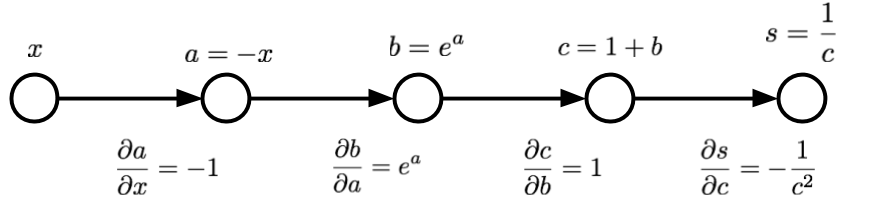

In [28]:
# pytorch autodiff vs manual gradients via staged computation
# we are gonna compute the gradient of the sigmoid function = 1/ (1 + exp(-x))

def sigmoid(x):
    # sigmoid function reiplemented for clarity. use torch.sigmoig

    y = 1.0 / (1.0 + torch.exp(-x))
    return y

def grad_sigmoid_pytorch(x):
    x = x.clone().requires_grad_(True)
    y = sigmoid(x)
    y.backward()
    return x.grad

def grad_sigmoid_manual(x):
    #  implement the gradien of the logistic sigmoid function using staged computation

    # forward pass
    # This is where the parts of the sigmoid function were separated
    a = -x
    b = np.exp(a)
    c = 1 + b
    s = 1.0 / c

    # backward pass
    dsdc = -1 / (c**2)
    dsdb = dsdc * 1
    dsda = dsdb * torch.exp(a)
    dsdx = dsda * (-1)
    return dsdx


def grad_sigmoid_symbolic(x):

    # this is just computing the derivative of sigmoid function
    s = sigmoid(x)
    dsdx = s * (1-s)
    return dsdx

input_x = torch.tensor([2.0])
# Compare the results
print(f"""
    autograd: {grad_sigmoid_pytorch(input_x).item()}
    manual: {grad_sigmoid_manual(input_x).item()}
    symbolic: {grad_sigmoid_symbolic(input_x).item()}""")


    autograd: 0.10499356687068939
    manual: 0.10499357432126999
    symbolic: 0.10499362647533417


In [29]:
# implementing custom gradients: speed, numerical stability

class MySigmoid(torch.autograd.Function):
    # we can implement our own custom autograd functions by subclassing torch.autograd.Function and implementing the forward and backward passes which operate on tensors

    @staticmethod
    def forward(ctx, input):

        # in the forward we receive a tensor containing the input and return a tensor containing the output. ctx is a context object that can be used to stash information fro bacward computation. you can cache arbitrary objects for use in the backward pass using the cts.save_for_backward method

        ans = 1.0 / (1.0 + torch.exp(-input))
        ctx.save_for_backward(input, ans)
        return ans
    
    @staticmethod
    def backward(ctx, grad_output):

        #  in the backward pass we receive a tensor containing the gradient of the loss wrt the output and we need to compute the gradient of the loss wrt the input

        input, ans = ctx.saved_tensors
        return grad_output*ans*(1-ans)
    

my_sigmoid = MySigmoid.apply

x = input_x.clone().requires_grad_(True)
y = my_sigmoid(x)
y.backward()
x.grad.item()

0.10499362647533417

i:0 loss 122.0216
i:100 loss 9.2971
i:200 loss 6.3792
i:300 loss 4.6042
i:400 loss 3.5244
i:500 loss 2.8675
i:600 loss 2.4678
i:700 loss 2.2247
i:800 loss 2.0768
i:900 loss 1.9869
{'w': tensor([4.0874], requires_grad=True), 'b': tensor([9.4105], requires_grad=True)}


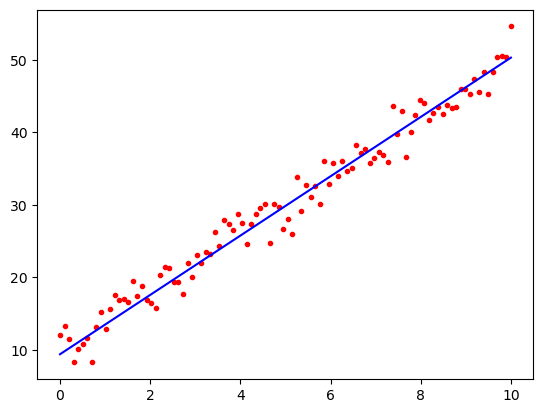

In [36]:
# Basic models: linear regression

N = 100 # number of training data points

# Define input data and label
x = np.linspace(0,10,N)
t = 4 * x + 10 + npr.normal(0,2,x.shape[0])

plt.plot(x,t, "r.")

# convert to pytorch tensors
x = torch.from_numpy(x)
t = torch.from_numpy(t)

# initialize random parameters
params = {
    "w": torch.randn(1).requires_grad_(True),
    "b":torch.randn(1).requires_grad_(True),
}

def cost(params):

    y = params["w"] * x + params["b"]
    return (1/N) * torch.sum(0.5*(y-t)**2)

# find the gradient of the cost function using pytorch
num_epochs = 1000 # number of epochs for training
alpha = 0.01  # learning rate

for i in range(num_epochs):
    loss = cost(params)

    loss.backward()

    if i%100 == 0 :
        print(f"i:{i} loss {loss.item():.4f}")

    # update the parameters w and b
    # no grad disables gradient calculation; primarily used for inference
    with torch.no_grad():
        params['w'].data = params['w'] - alpha*params['w'].grad
        params['b'].data = params['b'] - alpha*params['b'].grad
        
        # fills the tensor grad with zeros
        params['w'].grad.zero_()
        params['b'].grad.zero_()

print(params)        

# plotting the learned parameters as a line
plt.plot([0,10], [params['b'].detach().numpy(), params['w'].detach().numpy()*10 + params['b'].detach().numpy()], "b-")

torch.Size([5, 1])
i: 0 loss 386.4263
i: 100 loss 74.5780
i: 200 loss 59.9376
i: 300 loss 49.2491
i: 400 loss 41.3711
i: 500 loss 35.4987
i: 600 loss 31.0638
i: 700 loss 27.6652
i: 800 loss 25.0187
i: 900 loss 22.9223
tensor([[-1.9083],
        [ 4.3656],
        [-6.7874],
        [ 0.8729],
        [ 0.5927]], requires_grad=True)


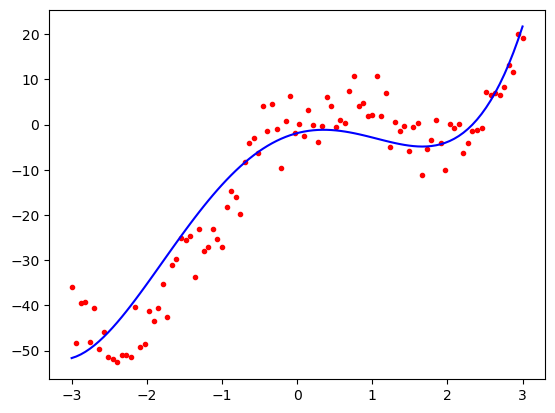

In [40]:
# linear regression with a feature mapping: we will fit a polynomial using linear regression with a polynomial featyre mapping with a noise randim variable
# we will perform a fixed nonlinear transformation of the inputs and the model is still linear in the parameters. we can define a set of feature mappings - aka features functions or basis functions - rho to implement the fixed transformations

N = 100
x = np.linspace(-3,3, N)
t = x**4 - 10*x**2 + 10*x + npr.normal(0,4, x.shape[0])

plt.plot(x,t, 'r.')

# returns the same tensor but of a different shape: in this case it is a column vector
t =torch.from_numpy(t).view(-1,1)


# degree of a polynomial 
M = 4

feature_matrix = torch.tensor([[item**i for i in range(M+1)] for item in x], dtype=torch.float32)

params = {
    'w': torch.randn(M+1,1).requires_grad_(True),
}
print(params['w'].shape)

def cost(params):
    # perform matrix multiplication of the matrices
    y = torch.mm(feature_matrix, params['w'])
    return (1/N) * torch.sum(0.5*(y-t)**2)



# compute gradient

num_epochs = 1000
learning_rate = 0.001

for i in range(num_epochs):

    loss = cost(params)
    loss.backward()


    if i%100 == 0:
        print(f"i: {i} loss {loss.item():.4f}")


    # update the parameters while grad is turned off
    with torch.no_grad():

        params['w'].data = params['w'] - learning_rate*params['w'].grad
        params['w'].grad.zero_()


print(params['w'])

w = params['w'].detach().cpu().numpy()

plt.plot(x, np.dot(feature_matrix, w), "b-")
    

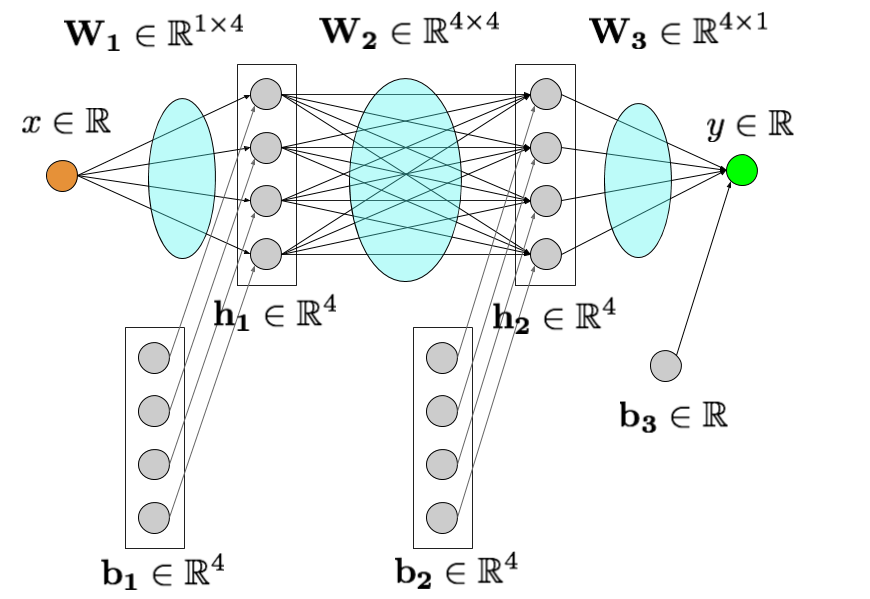

{'w1': tensor([[-1.7195,  0.5968, -0.3498, -0.3127]], requires_grad=True), 'b1': tensor([ 0.7242, -0.8444,  1.6540, -0.0397], requires_grad=True), 'w2': tensor([[ 0.0892,  0.5255, -0.0610, -0.1395],
        [-0.8701, -0.3906,  0.7921, -0.3716],
        [-1.9319, -1.5339,  0.8660, -0.6698],
        [ 1.4073,  0.3859, -0.5220,  0.3337]], requires_grad=True), 'b2': tensor([ 0.5395,  0.0064,  1.6271, -1.3466], requires_grad=True), 'w3': tensor([[ 0.5492],
        [-2.0717],
        [ 0.2431],
        [ 0.5395]], requires_grad=True), 'b3': tensor([-0.0423], requires_grad=True)}
tensor(335.3066, dtype=torch.float64, grad_fn=<MulBackward0>)
i:0 loss 335.3066
i:500 loss 108.6772
i:1000 loss 72.4992
i:1500 loss 70.0261
i:2000 loss 68.8135
i:2500 loss 68.1593
i:3000 loss 67.7217
i:3500 loss 67.4425
i:4000 loss 67.2799
i:4500 loss 67.1598
i:5000 loss 67.0787
i:5500 loss 67.0347
i:6000 loss 67.0152
i:6500 loss 67.0069
i:7000 loss 67.0030
i:7500 loss 67.0017
i:8000 loss 67.0012
i:8500 loss 67.0010


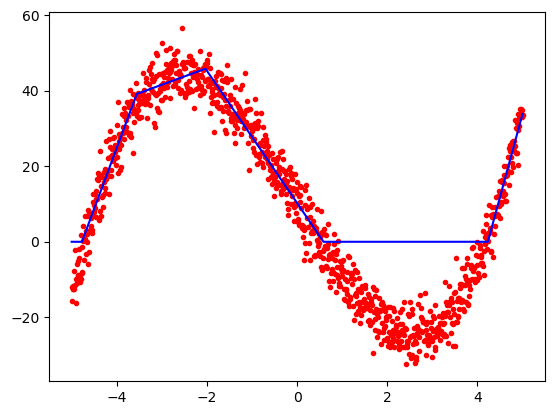

In [51]:
# neural net regression: we will implement nonlienear regression model using neural network

x = np.linspace(-5,5,1000)
t = x**3 - 20*x +10+npr.normal(0,4,x.shape[0])
plt.plot(x,t, 'r.')

# get tensors
x = torch.from_numpy(x).float()
t = torch.from_numpy(t)

inputs = x.reshape(x.shape[-1], 1)

params = {
    "w1":torch.randn(1,4).requires_grad_(True),
    "b1":torch.randn(4).requires_grad_(True),
    "w2":torch.randn(4,4).requires_grad_(True),
    "b2":torch.randn(4).requires_grad_(True),
    "w3":torch.randn(4,1).requires_grad_(True),
    "b3":torch.randn(1).requires_grad_(True),
}
print(params)

# we can define an optimizer which takes care of updating parameters based on their gradient. we can use more complex optimizers like sgd+momntum or adam
optimizer = torch.optim.SGD(params.values(), lr=0.0001, weight_decay=0.0001, momentum=0.9)

# pytorch also has implementation of wide range of activation functions
nonlineariry = torch.nn.ReLU()

def predict(params, inputs):
    h1 = nonlineariry(torch.mm(inputs, params['w1'])+params['b1'])
    h2 = nonlineariry(torch.mm(h1, params['w2'])+params['b2'])
    output = nonlineariry(torch.mm(h2, params['w3'])+params['b3'])

    return output

def cost(params):

    output = predict(params, inputs)
    return (1.0/inputs.shape[0]) * torch.sum(0.5*(output.reshape(output.shape[0])-t)**2)

print(cost(params))
    

num_epochs = 10000

for i in range(num_epochs):

    loss = cost(params)

    if i%500 == 0 :
        print(f"i:{i} loss {loss.item():0.4f}")

    # resets the gradient of all optimized tensors
    optimizer.zero_grad()
    
    # computes gradient of current wrt graph leaves
    loss.backward()
    
    # performs single optimization step (parameter update)
    optimizer.step()

with torch.no_grad():

    final_y = predict(params, inputs)
    plt.plot(x,final_y, 'b-')


In [ ]:
# neural networks models: mnist classification